<a href="https://colab.research.google.com/github/KIIIIT00/B3_Spring/blob/main/MNIST_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **B3_Spring** ###

- Summary: Robustness evaluation on noisy data.
- Objective: Train on MNIST images with added noise and verify robustness.

In [1]:
# Install necessary libraries
!pip install torch torchvision tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Import necessary libraries
import os
import math
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



### Class and method definitions ###
* add_noise : Add noise and clip pixel values to [0, 1].
* NoisyMNIST : Create a noisy dataset.
* MNIST_CNN : CNN class for classifying handwritten digits
  * forward : Performs forward propagation
  * save_model : Saves the model
  * load_model : Loads the model
* train_model : Model Training Function
* show_mnist_comparison : Displays the original images, labels, and predictions

In [17]:
def add_noise(images, noise_factor=0.3):
  """ノイズを追加する関数"""
  noise = torch.randn_like(images) * noise_factor
  noisy_images = images + noise
  return torch.clamp(noisy_images, -1.0, 1.0)

class NoisyMNIST(torch.utils.data.Dataset):
  """ノイズ付きデータセットを作成するクラス"""
  def __init__(self, dataset, noise_factor=0.3):
    self.dataset = dataset
    self.noise_factor = noise_factor

  def __getitem__(self, index):
    image, label = self.dataset[index]
    noisy_image = add_noise(image, self.noise_factor)
    return noisy_image, label

  def __len__(self):
    return len(self.dataset)

class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 14 * 14, 128)
    self.fc2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()


  def forward(self, x):
    x = self.relu(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def save_model(self, model_name):
    torch.save(self.state_dict(), f"{model_name}.pth")

  def load_model(self, model_name):
      if os.path.exists(f"{model_name}.pth"):
          self.load_state_dict(torch.load(f"{model_name}.pth"))
          print("Model loaded successfully")
      else:
          print("Model not found")

def train_model(model, train_loader, test_loader, epochs=5, learning_rate=0.001):
  """モデルの学習関数"""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  test_accuracies = []

  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      avg_train_loss = running_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # Evaluate model
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      test_accuracy = 100 * correct / total
      test_accuracies.append(test_accuracy)

      print(f"Epoch {epoch+1}: Loss = {avg_train_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")

  return train_losses, test_accuracies

def show_mnist_comparison(originals, images, labels, predictions):
    """ 元の画像・ラベル・予測結果を比較表示する関数 """
    num_images = len(images)
    cols = min(5, num_images)  # Display up to 5 images per row
    rows = math.ceil(num_images / cols) * 2  # Need twice the number of rows for comparison

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.subplots_adjust(hspace=0.5) # Increase spacing between images and titles

    for i in range(num_images):
        # Original images (First row)
        ax = axes[i // cols * 2, i % cols]
        orig_img = originals[i].cpu().numpy().squeeze()
        ax.imshow(orig_img, cmap="gray")
        if isinstance(labels[i], torch.Tensor):
            label = labels[i].item()
        else:
            label = labels[i]
        ax.set_title(f"Original Label: {label}", fontsize=10, pad=8)  # Adjust padding using `pad`
        ax.axis("off")

        # Predicted images (Second row)
        ax = axes[i // cols * 2 + 1, i % cols]
        pred_img = images[i].cpu().numpy().squeeze()
        ax.imshow(pred_img, cmap="gray")
        ax.set_title(f"Pred Label: {predictions[i].item()}", fontsize=10, pad=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def plot_results(normal_losses, normal_acc, noisy_losses, noisy_acc):
    """ 結果をプロットする関数 """
    plt.figure(figsize=(10, 4))

    # Comparsion of Loss
    plt.subplot(1, 2, 1)
    plt.plot(normal_losses, label="Normal Training Loss")
    plt.plot(noisy_losses, label="Noisy Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Comparsion of Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(normal_acc, label="Normal Test Accuracy")
    plt.plot(noisy_acc, label="Noisy Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.suptitle("Comparison of Normal vs Noisy Training")
    plt.show()

## Preprocessing ##

In [4]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load MNIST Dataset ##

In [5]:
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

noisy_train_dataset = NoisyMNIST(train_dataset, noise_factor=0.3)
noisy_test_dataset = NoisyMNIST(test_dataset, noise_factor=0.3)

noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 352kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Learning ##

In [6]:
# Training on normal data
print("\nTraining on normal images:")
model_normal = MNIST_CNN()
normal_train_losses, normal_test_accuracies = train_model(model_normal, train_loader, test_loader)

# Training on noisy data
print("\nTraining on noisy images:")
model_noisy = MNIST_CNN()
noisy_train_losses, noisy_test_accuracies = train_model(model_noisy, noisy_train_loader, noisy_test_loader)


Training on normal images:
Epoch 1: Loss = 0.1552, Test Accuracy = 98.50%
Epoch 2: Loss = 0.0443, Test Accuracy = 98.42%
Epoch 3: Loss = 0.0284, Test Accuracy = 98.66%
Epoch 4: Loss = 0.0204, Test Accuracy = 98.82%
Epoch 5: Loss = 0.0154, Test Accuracy = 98.71%

Training on noisy images:
Epoch 1: Loss = 0.1670, Test Accuracy = 98.20%
Epoch 2: Loss = 0.0486, Test Accuracy = 98.48%
Epoch 3: Loss = 0.0341, Test Accuracy = 98.51%
Epoch 4: Loss = 0.0242, Test Accuracy = 98.88%
Epoch 5: Loss = 0.0189, Test Accuracy = 98.88%


## Result ##

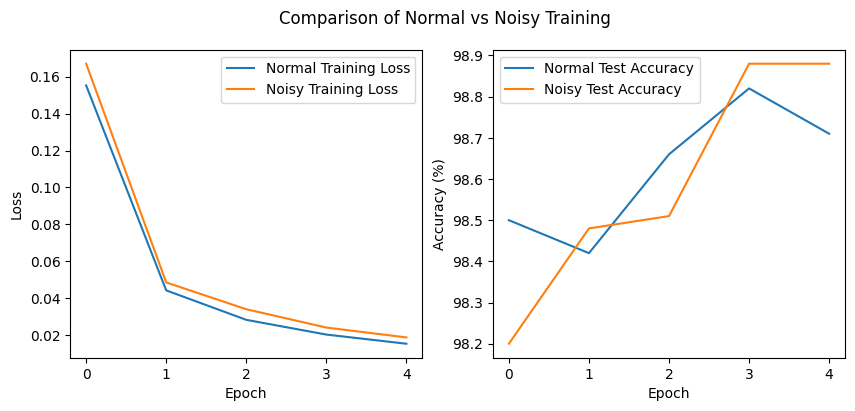

In [7]:
plot_results(normal_train_losses, normal_test_accuracies, noisy_train_losses, noisy_test_accuracies)

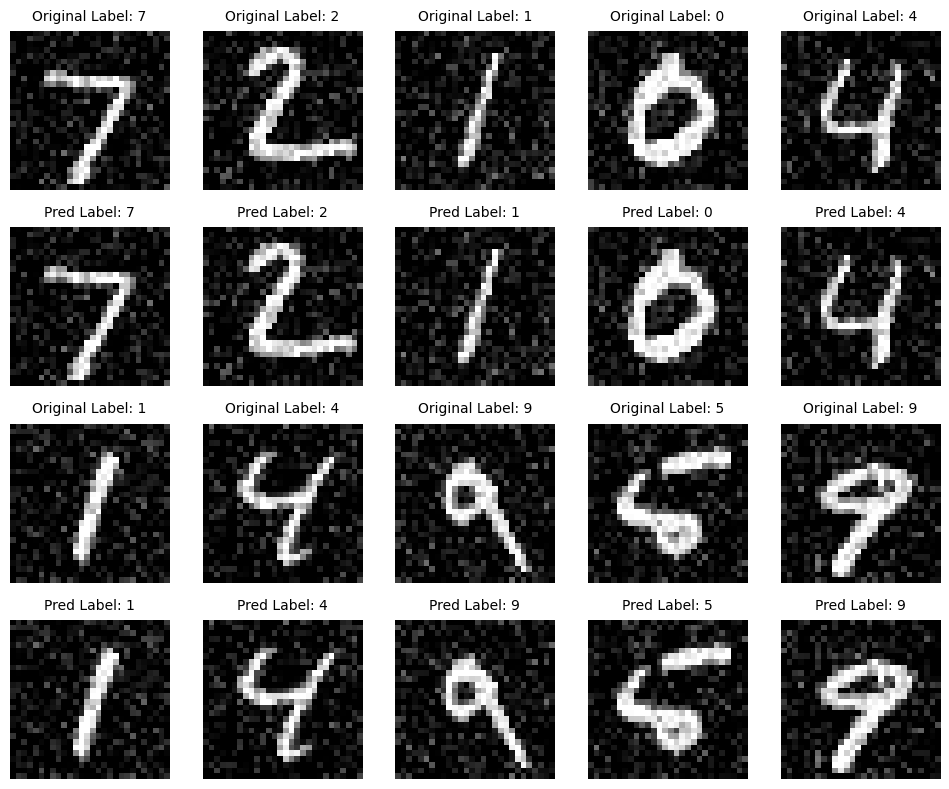

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_images = 10
noisy_originals, lables = zip(*[noisy_test_dataset[i] for i in range(num_images)])
noisy_images = torch.stack(noisy_originals).to(device)

model_noisy.eval()

# Batch processing
noisy_images = noisy_images.to(device)

# Prediction
with torch.no_grad():
    predictions = model_noisy(noisy_images).argmax(dim=1)

#Display images, labels, and predictions
show_mnist_comparison(noisy_originals, noisy_images, lables, predictions)



### **Advanced Topics** ###
* Summary : Denoising Autoencoder
* Objcevite : Construct, train, and evaluate a model that takes noisy images as input and outputs denoised images.



### Class and method definitions ###
* DenoisigingAutoencoder : CNN Autoencoder Model.
 * forward : Performs forward propagation
* train_autoencoder_model : Model Training Function
* visualize_denoising : Visualize Noise Removal

In [23]:
class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

def train_autoencoder_model(model, train_loader, num_epochs=5):
  """モデルの学習関数"""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(num_epochs):
      for images, _ in train_loader:
          images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
          noisy_images = add_noise(images)
          optimizer.zero_grad()
          outputs = model(noisy_images)
          loss = criterion(outputs, images)
          loss.backward()
          optimizer.step()
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

def visualize_denoising(model, test_loader):
  """ノイズ除去の可視化をする関数"""
  model.eval()
  with torch.no_grad():
      for images, _ in test_loader:
          images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
          noisy_images = add_noise(images)
          outputs = model(noisy_images)
          break

  fig, axes = plt.subplots(3, 7, figsize=(12, 6))
  labels = ["Original", "Noisy", "Denoised"]
  for row in range(3):
        axes[row, 0].text(-0.5, 0.5, labels[row], va='center', ha='center', fontsize=12, transform=axes[row, 0].transAxes)
        axes[row, 0].axis("off")

  for i in range(6):
      axes[0, i + 1].imshow(images[i].cpu().squeeze(), cmap="gray")
      axes[1, i + 1].imshow(noisy_images[i].cpu().squeeze(), cmap="gray")
      axes[2, i + 1].imshow(outputs[i].cpu().squeeze(), cmap="gray")

      for row in range(3):
          axes[row, i + 1].axis("off")
  fig.subplots_adjust(left=0.15)
  plt.show()


## Preprocessing ##

In [20]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load MNIST Dataset ##

In [21]:
batch_size = 64
train_encoder_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_encoder_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_encoder_loader = torch.utils.data.DataLoader(train_encoder_dataset, batch_size=batch_size, shuffle=True)
test_encoder_loader = torch.utils.data.DataLoader(test_encoder_dataset, batch_size=batch_size, shuffle=False)

## Learning ##

In [24]:
model = DenoisingAutoencoder()
train_autoencoder_model(model, train_encoder_loader)

Epoch [1/5], Loss: 0.0151
Epoch [2/5], Loss: 0.0135
Epoch [3/5], Loss: 0.0140
Epoch [4/5], Loss: 0.0095
Epoch [5/5], Loss: 0.0109


## Result ##

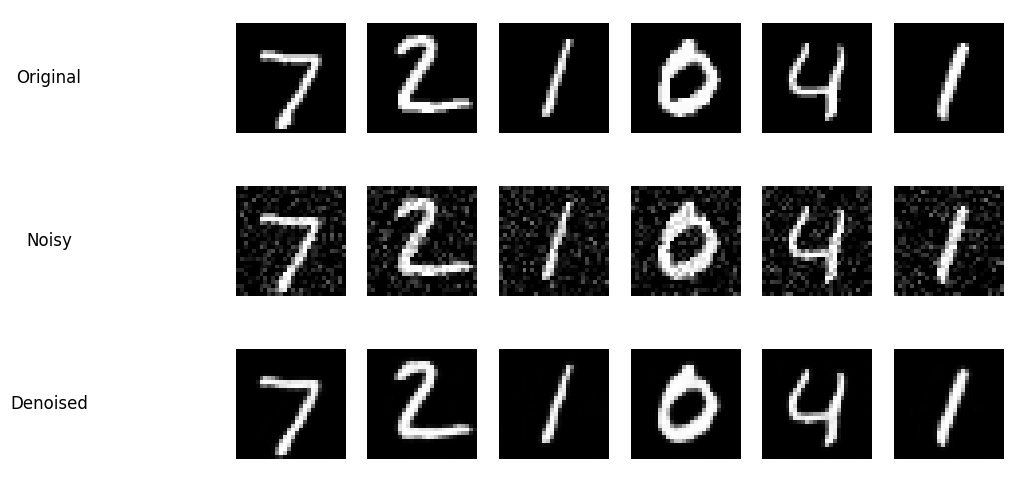

In [25]:
visualize_denoising(model, test_encoder_loader)